# Introduction
The purpose of this notebook is to solve supply chain problems with python. I'm a MIT Micro Masters in supply chain management student. While solving the MIT practise questions on excel I have decided to implement the models in Python as well thereby we can reuse and can save a lot of time in future. As well as building supply chain models in Python with come with additional data visualization features of python, this help us to automate lot of the work and solve complex problems very easily.

### MIT Micromasters in Supply Chain Management
This notebook uses the questions and models from the MIT Micromasters course materials, therefore all rights belongs to MIT. I have did my part on implemting the models in python and solved the practice and example problems.

## Transportation Problem
This notebook builds a solution for transportation problem with Pyomo library.


In [275]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pyomo.environ import *

In [276]:
Supply = {
    'P1':100,
    'P2':125
}

Demand = {
    'R1':25,
    'R2':95,
    'R3':80
}

Distance = {
    ('P1','R1') : 250,
    ('P1','R2')  : 325,
    ('P1','R3')   : 445,
    ('P2','R1') : 275,
    ('P2','R2')  : 260,
    ('P2','R3')   : 460
}

UnitCost = 1

In [277]:
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

model.i = Set(initialize=Supply.keys(), doc='Plants')
model.j = Set(initialize=Demand.keys(), doc='Regions')

model.d = Param(model.i, model.j, initialize=Distance, doc='Distance in miles')
model.f = Param(initialize=UnitCost, doc='Freight cost in dollars per mile')

# Function to calculate cost 
def c_init(model, i, j):
  return model.f * model.d[i,j]

model.c = Param(model.i, model.j, initialize=c_init, doc='Transport cost in dollar per case')

# Initialize flow on arc as a variable
model.x = Var(model.i, model.j, bounds=(0.0,None),domain = NonNegativeReals, doc='Shipment quantities')

# Function to get objective function rule
def objective_rule(model):
  return sum(model.c[i,j]*model.x[i,j] for i in model.i for j in model.j)

model.cost = Objective(rule=objective_rule, sense=minimize, doc='Total cost')

#Define constraints
def supply_rule(model, i):
  return sum(model.x[i,j] for j in model.j) <= Supply[i]
model.supply = Constraint(model.i, rule=supply_rule, doc='Observe supply limit at plant i')

def demand_rule(model, j):
  return sum(model.x[i,j] for i in model.i) >= Demand[j]  
model.demand = Constraint(model.j, rule=demand_rule, doc='Satisfy demand at market j')

#Solve the model with GLPK solver
results = SolverFactory('glpk').solve(model)

In [278]:
r = []
if 'ok' == str(results.Solver.status):
    print("Total Shipping Costs = ",model.cost())
    for i in model.i:
        for j in model.j:
            if model.x[i,j]() > 0:
                r.append((i,j,model.x[i,j](),model.d[i,j],model.c[i,j]))
                
    result_df = pd.DataFrame(r, columns=['Plant','Region','Flow','Distance','Cost'])
else:
    print("No Valid Solution Found")

Total Shipping Costs =  66625.0


In [279]:
result_df

,Plant,Region,Flow,Distance,Cost
0,P2,R2,95.0,260,260
1,P2,R3,5.0,460,460
2,P1,R1,25.0,250,250
3,P1,R3,75.0,445,445


## Visualize network solution

In [285]:
def draw_graph(flow, plants, regions):
    # create networkx graph
    G=nx.DiGraph()
    
    # add nodes
    G.add_nodes_from(plants, s=",")    
    G.add_nodes_from(regions, s="o")
    
    plant_color = []
    market_color = []
    
    for i in plants:
        plant_color.append('orange')

    for j in regions:
        market_color.append('blue')
    
    # add edges
    G.add_edges_from(flow)
    graph_pos = nx.kamada_kawai_layout(G)
    
    nodeShapes = set((aShape[1]["s"] for aShape in G.nodes(data = True)))
    
    #For each node class...
    for aShape in nodeShapes:
        if aShape == ',':
            color_map = plant_color
        else:
            color_map = market_color
            
        nx.draw_networkx_nodes(G,graph_pos,node_shape = aShape, nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))],node_size=1000, node_color=color_map, alpha=0.3)
    
    nx.draw_networkx_edges(G, graph_pos, width=2, alpha=0.3, edge_color='green')
    nx.draw_networkx_labels(G, graph_pos, font_size=12, font_family='sans-serif')
    
    plt.axis('off')
    plt.show()

In [286]:
flow = result_df[['Plant','Region']].values.tolist()
plants = result_df['Plant'].drop_duplicates().values.tolist()
regions = result_df['Region'].drop_duplicates().values.tolist() 

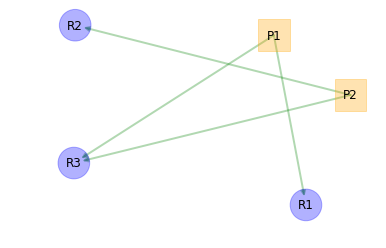

In [287]:
draw_graph(flow,plants,regions)

## Sensitivity Analysis
### Analysis by plant

In [283]:
s = []
for i in model.i:
    s.append((i,Supply[i],model.supply[i](),model.dual[model.supply[i]]))
    
supply_sensitivity = pd.DataFrame(s, columns=['Plant','Capacity','Utilized','Marginal_cost'])
supply_sensitivity

,Plant,Capacity,Utilized,Marginal_cost
0,P2,125,100.0,0.0
1,P1,100,100.0,-15.0


### Analysis by market

In [284]:
r = []
for j in model.j:
    r.append((j,Demand[j],model.demand[j](),model.dual[model.demand[j]]))
    
supply_sensitivity = pd.DataFrame(r, columns=['Region','Demand','Fullfilled','Marginal_cost'])
supply_sensitivity

,Region,Demand,Fullfilled,Marginal_cost
0,R1,25,25.0,265.0
1,R2,95,95.0,260.0
2,R3,80,80.0,460.0
